# Introduction
This notebook provides a synopsis of how I approached a recent problem that my employer was faced with. They had thousands of individual scanned aerial images  that in the future would be turned into larger mosaiced images. A main problem was that the naming convention that was used when these aerial images were scanned and created was not useful for future use. Each aerial image had information printed on the image that was related to the specific planned flight project, the roll of film number from the project and the image number from the roll of film. Being able to rename each image file using this information would make it much easier to store, search and ultimately to mosaic and orthorectify these images into landscape scenes. The initial prospect was to open each file, read the text on the image and then rename the file. I proposed at least looking into using optical character recognition as a way to automate a time consuming and mundane task. The following notebook provides steps on how I went about performing this task. 


Before beginning this notebook you will need to install tesseract. This is a stand alone
application with command line functionality. For [Windows](https://github.com/UB-Mannheim/tesseract/wiki) installation of tesseract for [Linx and Mac](https://github.com/tesseract-ocr/tesseract/wiki#windows)

Once tesseract is installled if you have Anaconda installation you can use the Anconda Prompt to install all of the python libraries  
and their dependencies. In the Anaconda Prompt change directories so that you are in the local copy of this repository. In the prompt then enter: 

*conda env create*  
once the environment is created enter:  
*conda activate imageOCR*  
then enter:  
*jupyter lab*

From here open the notebook entitled *ImageOCR.ipynb*

## Packages we will use
The primary packages that we will use are [PIL](https://pypi.org/project/Pillow/) an image processing library.  
[Pytesseract](https://pypi.org/project/pytesseract/) a python wrapper for the installation of tesseract which we use to read the text on the image.  
Lastly, [Matplotlib](https://matplotlib.org/) to display the images after performing cropping and covolutions.

The GitHub repository where this notebook is stored contains a requirements.txt file which can be used with Conda  
to create a virtual environment with all of the required and dependent Python packages to run this notebook. 

# Importing and other requirements 
Now we'll import our packages and take care of some other potential issues that will help to be able to use this notebook

In [1]:
from PIL import (
    Image,
    ImageFilter,
    ImageOps
)
from helperFunctions import checkTesseractPath

import pytesseract
from matplotlib import pyplot as plt
import glob
#import os
#import zipfile
#import sys


# a function that can be found in the readTextOnPhoto.py to help check and see if path to tesseract is set so pytesseract can use it
checkTesseractPath() 

#################
# in the event you recieve a message that you must set the path to tesseract
# find the path to tesseract.exe uncomment the line below and re-run this cell
#pytesseract.pytesseract.tesseract_cmd = 
##################

# The image that we are looking at isn't that large. But setting the MAX IMAGE PIXELS ensures we don't have any unecessary memory issues. 
Image.MAX_IMAGE_PIXELS = None

#### DRY (Don't Repeat Yourself)
This is a bit of an aside but a best practice in writing code and software development is to *__don't repeat yourself__* (DRY).  
Throught this notebook we will want to display the images. We'll use a call to matplotlib *__.imshow()__*
to display the images frequently throughout this notebook.  
Let's wrap it up into a function for continued use with less repitition.

In [2]:
def displayImage(image, figureTitle): # our function arguments are an input image, and title for restulting figure 
    plt.imshow(image, cmap='gray') # we set the keyword argument "cmap", which is the colormapping of our image to grayscale
    plt.axis('off') # axes are not helpful in this instance
    plt.title(figureTitle) # we'll use the title to remind us of any processing we did to our image 

# Looking at our first image
Let's load a single image to see what we are working with.

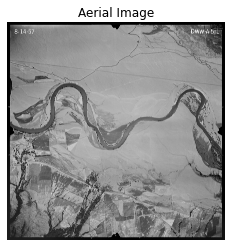

In [3]:
file =  r'images\singleImage\0F6185_0001_2.tif'
img = Image.open(file)

displayImage(img, 'Aerial Image') # our first call to our newly defined function

As we can see there is information printed in the top of the image.

For the sake of the size of this GitHub repository's size I have taken the liberty to pre crop all the rest of the images we will be working with.  
If you're interested in learning about cropping the call to the PIL library is [*.crop()*](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=crop#PIL.Image.Image.crop) where the only argument is a tuple with the dimensions *(left, upper, right, lower)* of the part image you wish to retain.  

Let's load this pre cropped image to look at the information in the top right of the fullsize image.



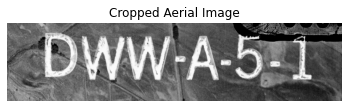

In [4]:
file = r'images\croppedImages\0F6185_0001_clipped.tif'
img = Image.open(file)

displayImage(img, 'Cropped Aerial Image')

In the image there are a mix of characters, numbers and symbols. This is the information we want to use to rename this image.  

*__DWW-A__:* is the project  

*__5__:* is the roll of film on this aeral images flight line  

*__1__:* is the picture number on the film roll.


## What would happen if we try and read this text directly off this image?

We'll give it a try but first let's take a look at some of the keyword arguments that we use in our call to  
*__pytesseract.image_to_string()__* in the next code block

Tesseract has different configurations that can be used when trying to read text.  

Here the keyword argument "__lang__" is set to english.  

In our "__config__" argument we use *--psm 7*. This argument stands for *page segmentation mode.*\
Looking at the tesseract [documentation](https://github.com/tesseract-ocr/tesseract/blob/master/doc/tesseract.1.asc) we can see that using __7__ will treat the image as a single line of text.  

The last argument "__tessedit_char_whitelist__" allows control over the characters that tesseract is allowed to consider when reading text on a image.  
Here the argument is set to allow for all numbers and all capitalized letters as well as a hyphen symbol.

In [5]:
text = pytesseract.image_to_string(
    img, 
    lang='eng',
    config='--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-')

Before printing the text read by the call to tesseract we will remove any carriage returns and strip white space  from the text read on the image. 

The text on the image is being read as: 4 7 E


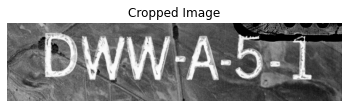

In [6]:
text = text.strip('\n')
text = text.strip()
print('The text on the image is being read as:', text)

displayImage(img, 'Cropped Image')

We can see that these results are not very satisfactory.  
Only three characters were detected and none of them are in this image.

Let's try and invert the image and see if that helps.

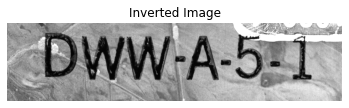

In [7]:
img = ImageOps.invert(img)

displayImage(img, 'Inverted Image')

Let's see if inverting the image will improve tesseract's ability to read the text on this image.  


### More DRY
We will continue to use the same lines of code related to reading and printing the text on the image. Let's wrap this code in a function. 

In [8]:
def readTextAndPrint(image):
    text = pytesseract.image_to_string(
        image,
        lang='eng',
        config='--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-')
    
    text = text.strip('\n')
    text = text.strip()
    print('The text on the image is being read as:', text)

Now let's see inverting the image made reading the text any easier.

In [9]:
readTextAndPrint(img) # the first call to our read text function

The text on the image is being read as: NF


Again, we can see that these results are not very satisfactory. This time we only predicted 
2 characters and again neither of them is in this image.  

## Image Convolution 

Let's implement some image processing steps to isolate the text on the image and make all other pixels in the image white.  
First we will get the dimensions of our cropped image.

In [10]:
imageWidth, imageHeight = img.size
print ('Our Image is', imageWidth, 'x', imageHeight, 'pixels')

Our Image is 3000 x 700 pixels


Next we will use the PIL *__.load()__* function. As stated in the PIL documentation when using the __Image.open()__ function:\
*This is a lazy operation; this function identifies the file, but the file remains open and the\
actual image data is not read from the file until you try to process the data (or call the load() method)*  
Making the call to *__.load__* and setting it to *imagePixel* allows us access to the underlying pixels in the image.  
We will still refer to img when displaying. 

In [11]:
imagePixels = img.load()

Our image is being displayed in 8-bit gray scale, so any pixel value in our image could have a value between 0-255.  
Now we will nest two for loops to go through each pixel in our image and determine if a pixel is greater than value of 40.  
If a pixels is greater than 40 it will be set to a pixel value of 255 which in this grayscale is equivalent to white.  
Pixels values that are less than 40 will retain their current value. I chose this value of 40 through previous experimentation. 

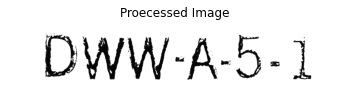

In [12]:
 for y in range(0, imageHeight):
    for x in range(0, imageWidth):
        if imagePixels[x, y] > 40:
            imagePixels[x, y] = 255
        else:
            pass
        
displayImage(img, 'Proecessed Image')

That process signficantly cleaned up the back ground and helped to isoltate the text. 
Now lets try reading the text on this cleaned up image. 

In [13]:
readTextAndPrint(img)

The text on the image is being read as: DWW-A-5-1


# SUCCESS!!!
Through these process steps we were able to use tesseract to correctly read the text on this image. 

I know from experience with other images that setting low pixel values to zero or black in this  
grayscale can help to thicken the text in the image and improve the ability of tesseract to correctly read the text. 

In this next code block we will go through each pixel as before and set those that are less than or equal to 11 in 8 bit range to 0.  
Again I picked the value 11 through previous experimentation.

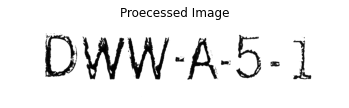

In [14]:
for y in range(0, imageHeight):
    for x in range(0, imageWidth):
        if imagePixels[x, y] <= 11:
            imagePixels[x, y] = 0
        else:
            pass

displayImage(img, 'Proecessed Image')

This last image convolution doesn't buy us much in this instance, but it can and will be helpful 
with reading text on other images. 

Let's try one more method to thicken the text on our image. 
Next, we will call the ImageFilter.MinFilter() back to back.  
MinFilter performs a moving window over the entire image where the *__size__* argument 
is the size of the window in pixels  
and the lowest pixel value in the window is returned to pixel in the center of the window. I was not able to find in the PIL [documentation](https://pillow.readthedocs.io/en/5.2.x/reference/ImageFilter.html)  
what the maximum size value is but a size of 5 was the largest that I could use. 

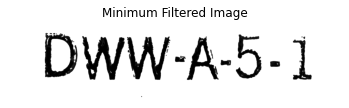

In [15]:
img = img.filter(ImageFilter.MinFilter(size=3))
img = img.filter(ImageFilter.MinFilter(size=5))

displayImage(img, 'Minimum Filtered Image')

### Another Function 
We'll make one last function as we'll be looping through a bunch of pre-cropped images to see how succesfully  
we can read the text on different scanned aerial images. 

In [16]:
def imageConvolution(file):
    img = Image.open(file)
    img = ImageOps.invert(img)
    imageWidth, imageHeight = img.size
    imagePixels = img.load()
    
    for y in range(0, imageHeight):
        for x in range(0, imageWidth):
            if imagePixels[x, y] > 40:
                imagePixels[x, y] = 255
            else:
                pass
    
    for y in range(0, imageHeight):
        for x in range(0, imageWidth):
            if imagePixels[x, y] <= 11:
                imagePixels[x, y] = 0
            else:
                pass
            
    img = img.filter(ImageFilter.MinFilter(size=3))
    img = img.filter(ImageFilter.MinFilter(size=5))
    
    return img

In [17]:
files = glob.glob(r'images\croppedImages\*.tif')

# here we use a for loop to process each cropped image and read the text on it
# using our previously defined functions
for file in files:
    processedImage = imageConvolution(file)
    readTextAndPrint(processedImage)

The text on the image is being read as: DWW-A-5-1
The text on the image is being read as: DWWAS-Z
The text on the image is being read as: 40-DWW-A-5-3
The text on the image is being read as: DWW-A-5-4
The text on the image is being read as: DWW-A-5-5
The text on the image is being read as: DWW-A-5-6
The text on the image is being read as: DWW-A-5-7
The text on the image is being read as: DW - - 2 8
The text on the image is being read as: DWW-AS-9-
The text on the image is being read as: 7 3 - OS -
The text on the image is being read as: 40-DWW-A-5-11
The text on the image is being read as: 0-DWW-A-512
The text on the image is being read as: DWW-A-5 -13
The text on the image is being read as: DWW-A-5-14
The text on the image is being read as: 
The text on the image is being read as: DWW-A-5-16
The text on the image is being read as: DWW-A5-17
The text on the image is being read as: DWW-A-5-18
The text on the image is being read as: DWW-A-5-19
The text on the image is being read as: 
The

KeyboardInterrupt: 

# Conclusion

As we can see from these results, we were approximately 60% accurate in reading the text that was printed on each image.  
The accuracy of this method was not as high as I would have liked but we did use this method in conjunction with some other techniques to rename many files.  
Ultimately the center that was scanning these aerial images switched their naming convention to be more in line with the convention that we were trying to use.  
Subsequently these optical character recognition efforts were no longer needed.


#### Futher Exploration
You can look at *ImageOCR_Part2* for a further exploration of why some of the images such as image 8 or 15 were not read properly